# Nested sampling
Nous avons vu en classe la procédure étape par étape du Nested sampling.
Le but de ce notebook est d'implémenter l'algorithme nous-même.
En pratique, pour le reste du cours, nous utiliserons dynesty.
On peut cependant acquérir une bonne intuition de comment le nested sampling fonction en codant une version simple.

L'algorithme est donné dans les diapos vues en classe et discuté en plus grand détail dans l'article de Skilling (2006) disponible sur StudiUM.

## Définition d'un modèle 1D simple

Pour commencer, nous allons tester notre implémentation sur une vraisemblance normale 1D avec une moyenne $\mu = 0$ et $\sigma = 1$, avec une distribution à priori entre -10 et 10.

### Transformation du prior

Pour implémenter le prior, il faut une "transformation du prior" (CDF inverse), comme nous avons vu en classe.
Cette fonction doit transformer des échantillons d'un intervalle unitaire vers la distribution souhaitée, soit $\mathcal{U}(-5, 5)$ dans ce cas-ci.

**Pour cette partie-ci, nous allons:**

- **Coder la transformation du prior dans la fonction `prior_transform()`.**
- **Tester notre transformation avec un échantillonnage aléatoire** (vérifiez que l'histogramme donne la distribution uniforme attendue entre -5 et 5.

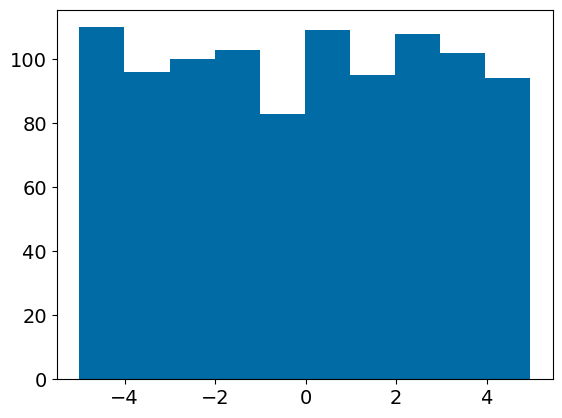

In [1]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import tqdm
from matplotlib import rcParams
from numpy.typing import NDArray

plt.style.use("tableau-colorblind10")

rcParams["font.size"] = 14

def prior_transform(u):
    p = u*10 - 5
    return p

u = np.random.uniform(low=0,high=1,size=1000)

plt.hist(prior_transform(u))
plt.show()
# TODO: prior transform et histogrammes

### Vraisemblance
Pour la vraisemblance, on utilise une distribution $p(D|\theta)$ gaussienne avec une seule mesure à $\theta_0 = 0$.
Implémentez le log de la vraisemblance.
Utilisez un écart type de $\sigma = 1$.

Comme la vraisemblance est facile à calculer. On peut d'abord l'afficher sur une grille.

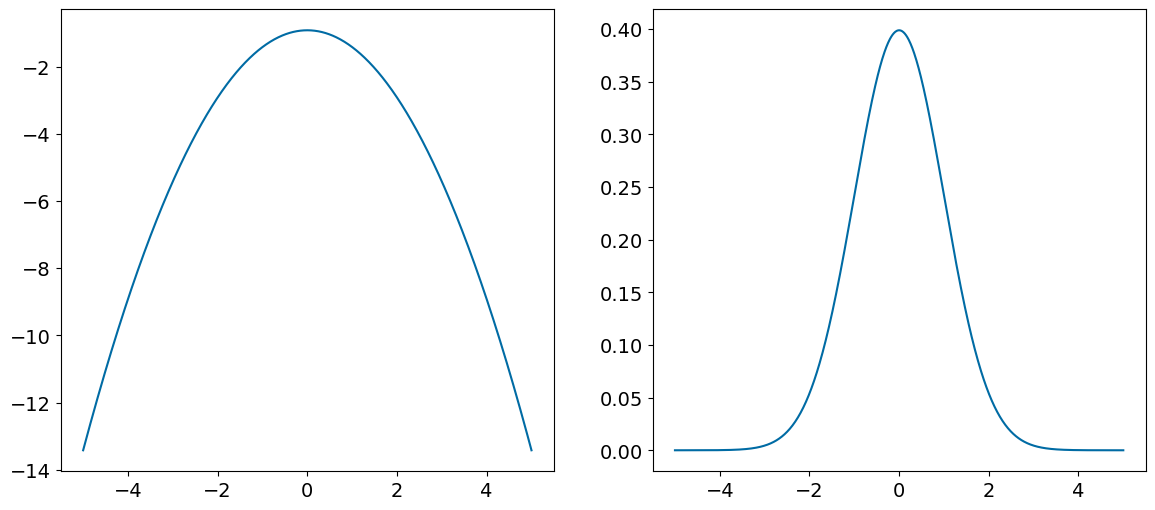

In [2]:
# TODO: Log-likelihood et évaluation sur grille

def log_likelihood(p, mu=0.0, sigma=1.0):
    theta = p
    return -0.5 * np.log(2*np.pi * sigma**2) - 0.5 * (theta-mu)**2/sigma**2

theta_vals = np.linspace(-5, 5, 1000)
fig, axs = plt.subplots(1,2,figsize=(14,6))

axs[0].plot(theta_vals, log_likelihood(theta_vals))
axs[1].plot(theta_vals, np.exp(log_likelihood(theta_vals)))
plt.show()

## Algorithme Nested Sampling

On peut maintenant implémenter le nested sampling.
Voici quelques suggestions ci-dessous.

- Pour commencer, utilisez un nombre fixe d'itérations (`nsteps`) au lieu d'un critère de convergence.
- Définissez une fonction `nested_sampling()` avec la signature suggérée ci-dessous. Les arguments sont:
  - `loglike_fn`: fonction log-vraisemblance, qui prend un argument `p` (vecteur du paramètre theta avec un seul élément).
  - `pt_fn`: fonction de _prior transform_
  - `ndim`: nombre de dimension du vecteur de paramètre (1, dans ce premier exemple)
  - `nlive`: nombre de live points. Commencez par quelques centaines. 500 fonctionne bien.
  - `nsteps`: nombre d'itérations maximum.
  - N'hésitez pas à coder une première version de votre algorithme hors de la fonction, pour avoir accès facilement aux variable et "débugger".
- Pour la génération de nouveaux "live points", vous pouvez utiliser le _rejection sampling_: générer des points sur tout le prior et accepter le premier point qui satisfait $L(\theta)>L_{\text{min}}$.
  - Ce n'est pas une manière efficace de générer des points. Je vous invite à tester des alternatives (e.g. MCMC à partir d'un _live point_ tiré au hasard, échantillonnage uniforme dans un ellipsoide) si le temps vous le permet.

100%|██████████| 5000/5000 [00:00<00:00, 7427.72it/s] 


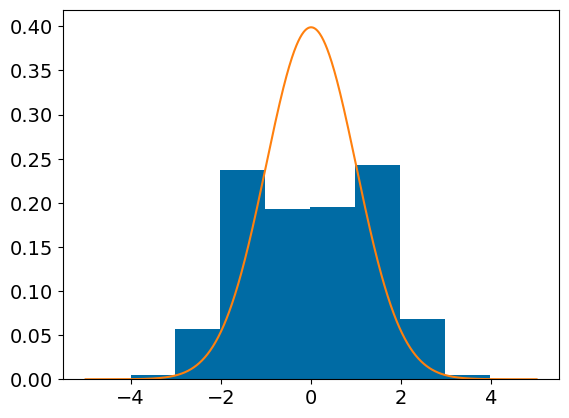

In [15]:
# TODO: Nested sampling

ndim = 1
nlive = 500
nsteps = 5000

u_ndim = np.random.uniform(0,1,size=(ndim,nsteps))
u_live = u_ndim[0]
p_live = prior_transform(u)
ll_live = log_likelihood(p_live)

p_dead = np.empty(nsteps)
ll_dead = np.empty(nsteps)
Z = np.empty(nsteps)
X = np.empty(nsteps)
w = np.empty(nsteps)

Xprev = 1.0
Zprev = 0.0

for i in tqdm.tqdm(range(nsteps)):
    min_ind = np.argmin(ll_live)
    
    p_min = p_live[min_ind]
    ll_min = ll_live[min_ind]
    
    p_dead[i] = p_min
    ll_dead[i] = ll_min
    
    Xi = np.exp(-i/nlive)
    dXi = Xprev - Xi 
    Xprev = Xi
    
    Z[i] = Zprev + ll_min * dXi
    X[i] = Xi
    w[i] = np.exp(ll_min) * dXi
    Zprev = Z[i]
    
    # if i % 100 == 0:
    #     plt.plot(p_live, ll_live, '.')
    #     plt.xlim([-5,5])
    #     plt.ylim((-12))
    #     plt.show()
    # 
    #New live point
    
    ll_new = - np.inf
    
    while ll_new <= ll_min:
        unew = np.random.uniform(0,1)
        pnew = prior_transform(unew)
        ll_new = log_likelihood(pnew)
    
    u_live[min_ind] = unew
    p_live[min_ind] = pnew
    ll_live[min_ind] = ll_new
    
plt.hist(p_dead, density=True, weights=w)
plt.plot(theta_vals, np.exp(log_likelihood(theta_vals)))
plt.show()



Vous pouvez maintenant afficher différentes quantités en fonction du volume du prior (ou de son logarithme):

- L'évidence
- La (log-)vraisemblance
- Le poid des échantillons
- Un histogramme pondéré de la distribution à posteriori

In [ ]:
# TOOD: Graphiques

## Exercices bonus
Si vous voulez explorer ce code un peu plus, voici quelques options. Elles ne seront pas évaluées, ni utilisées dans les devoir, mais elles sont intéressantes pour approfondir votre compréhension:

- Implémentez un échantillonnage par marche aléatoire
- Testez un modèle à deux paramètre (régression linéaire) avec ce code, comparez avec dynesty.

### MCMC

Dans ce cas-ci, notre MCMC sert à explorer la distribution a priori, et non la distribution a posteriori.

- Il faut donc utiliser une fonction `log_prior` pour explorer l'espace-paramètre. Définissez d'abord cette fonction.
- Il faut aussi rejeter les échantillons avec L < Lmin, en plus de l'acceptance MCMC habituelle.
- Pour l'échelle du MCMC, vous pouvez utiliser une distribution de proposition avec la taille du MCMC.
- Itérez un certain nombre d'itération (ex.: 1000) avant de prposer de nouveaux échantillons.

In [ ]:
# TODO: Définir une proposition MCMC et utiliser dans le nested sampling.

### Régression linéaire

On simule d'abord les données, on définit notre modèle probabiliste, et on lance ensuite le nested sampling.

In [ ]:
m_true = -0.9594
b_true = 4.294

N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [ ]:
# TODO: Prior, prior transform et likelihood.

In [ ]:
# TODO: Nested sampling